### 1. CNN으로 사람 얼굴 찾기
10_SVM.ipynb 파일에서 사용했던 사람 얼굴, 동물 이미지를 분류하는 작업을 CNN으로 개선해보자.  
SVM은 입력을 바로 처리하기 힘들어 HOG, 즉 이미지 각 픽셀의 기울기를 구하고 그 히스토그램을 분석을 위한 특징으로 활용했다.  
하지만 CNN은 이런 과정 없이 스스로 특징을 찾아낼 것이다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize

face_url = 'https://github.com/dknife/ML/raw/main/data/Proj2/faces/'

face_images = []
for i in range(15):
    file = face_url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))   #(64, 64, 3)
    face_images.append(img)
    
animal_url = 'https://github.com/dknife/ML/raw/main/data/Proj2/animals/'

animal_images = []
for i in range(15):
    file = animal_url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))   #이미지마다 크기가 다른데 (64, 64, 3)로 통일
    animal_images.append(img)    

c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize=(nCol, nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1:
                axis = ax[j]
            else:
                axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol + j])

<Figure size 432x288 with 0 Axes>

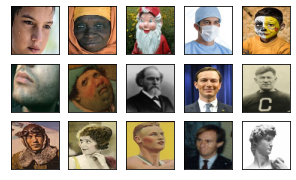

In [3]:
plot_images(3, 5, face_images)

<Figure size 432x288 with 0 Axes>

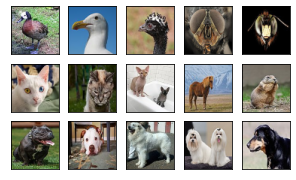

In [4]:
plot_images(3, 5, animal_images)

#### 학습데이터 만들기
사람 얼굴의 레이블은 [1,0], 동물의 레이블은 [0,1]로 지정해 y 배열을 만든다.

In [5]:
X = np.array(face_images + animal_images)
y = np.array([[1,0]] * 15 + [[0,1]] * 15)

X.shape, y.shape

((30, 64, 64, 3), (30, 2))

### 학습을 위한 CNN 모델 만들기
+ 입력 데이터 : (64, 64, 3)의 컬러이미지 30개
+ 첫번째 합성곱층에서 입력 데이터를 받아 (3,3) 필터 32종을 적용 => (62, 62)의 특징추출이미지 32장 생성(padding 적용 x)
+ 풀링층에서 (2,2)의 max pooling을 적용 => (31, 31)
+ 위 과정을 반복해 (4,4)의 특징추출이미지 32장을 얻은 후 일반적 신경망 적용
+ flatten 계층 적용 => 4x4x32 = 512개의 개별적 입력신호 얻음
+ Dense 계층으로 연결해 최종 2개(레이블 개수)까지 줄여나감

In [6]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([keras.layers.Conv2D(input_shape=(64,64,3), kernel_size=(3,3), filters=32),
                                 keras.layers.MaxPooling2D((2,2), strides=2),
                                 keras.layers.Conv2D(kernel_size=(3,3), filters=32),
                                 keras.layers.MaxPooling2D((2,2), strides=2),
                                 keras.layers.Conv2D(kernel_size=(3,3), filters=32),
                                 keras.layers.MaxPooling2D((2,2), strides=2),
                                 keras.layers.Conv2D(kernel_size=(3,3), filters=32),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(128, activation='relu'),
                                 keras.layers.Dense(16, activation='relu'),
                                 keras.layers.Dense(2, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          9

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, y, epochs=100, verbose=0)

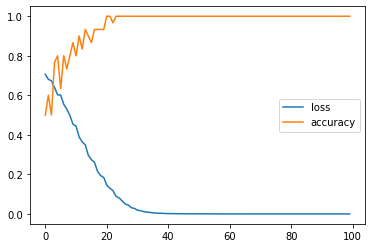

In [8]:
import pandas as pd
pd.DataFrame(history.history).plot();

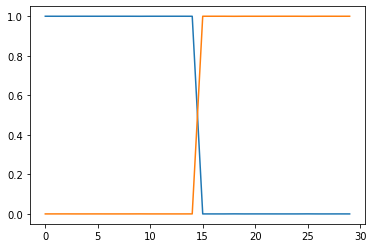

In [9]:
y_pred = model.predict(X)
plt.plot(y_pred);

1-15번째 데이터는 0, 16-30번째 데이터는 1로 예측해내는 것을 볼 수 있다.


### 새로운 데이터 예측해보기

<Figure size 432x288 with 0 Axes>

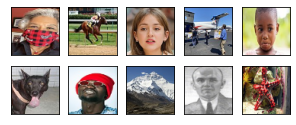

In [10]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/test_data/'

test_images = []
for i in range(10):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    test_images.append(img)
    
plot_images(2, 5, test_images)

In [11]:
test_images = np.array(test_images)
y_pred = model.predict(test_images)

[np.argmax(i) for i in y_pred]   #정답은 0 1 0 1 0 1 0 1 0 1  => 모두 잘 예측해냄

[0, 1, 0, 1, 0, 1, 0, 1, 0, 0]

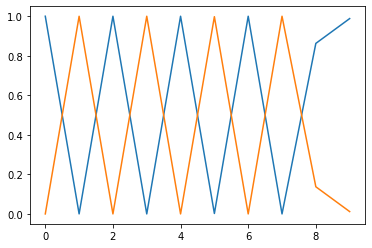

In [12]:
plt.plot(y_pred);

### 2. 전이학습으로 사람 얼굴 찾기
InceptionV3, VGG16 을 사용해보자.

In [13]:
face_url = 'https://github.com/dknife/ML/raw/main/data/Proj2/faces/'

face_images = []
for i in range(15):
    file = face_url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))   #InceptionV3의 최소입력크기인 (75, 75)로 resize => (75, 75, 3)
    face_images.append(img)
    
animal_url = 'https://github.com/dknife/ML/raw/main/data/Proj2/animals/'

animal_images = []
for i in range(15):
    file = animal_url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))   #(75, 75, 3)
    animal_images.append(img)    
    
X = np.array(face_images + animal_images)
y = np.array([[1,0]] * 15 + [[0,1]] * 15)

In [14]:
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model

pre_trained_model = InceptionV3(input_shape=(75,75,3),
                                include_top=False,
                                weights=None)

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

final_model = Model(pre_trained_model.input, x)

final_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
history = final_model.fit(X, y, epochs=100, shuffle=True, verbose=0)

In [16]:
pd.DataFrame(history.history)

,loss,accuracy
0,0.281482,0.5
1,0.499996,0.5
2,0.500000,0.5
3,0.500000,0.5
4,0.500000,0.5
...,...,...
95,0.500000,0.5
96,0.500000,0.5
97,0.500000,0.5
98,0.500000,0.5


정확도가 계속해서 50%인 것을 볼 수 있다.  
그 이유는 모델을 불러올 때 weights=None으로 가중치를 초기화해 처음부터 다시 훈련시키고 있고,  
새로운 학습에 사용한 데이터가 30개밖에 안되기 때문이다.  

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


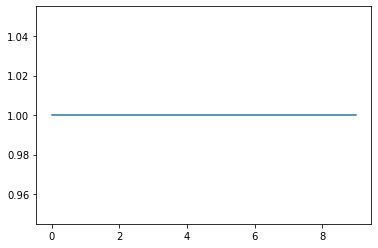

In [17]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/test_data/'

test_images = []
for i in range(10):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    test_images.append(img)
    
test_images = np.array(test_images)
y_pred = final_model.predict(test_images)

print([np.argmax(i) for i in y_pred])
plt.plot(y_pred);

검증데이터를 모두 사람 얼굴 이미지로 예측했다.

#### 사전학습된 모델의 능력을 유지하는 훈련
사전학습된 모델은 다양한 이미지를 훈련해 특징을 파악하는 능력을 이미 가지고 있는 상태이다.  
따라서 이런 능력을 무시하고 처음부터 새로 학습하는 일은 비효율적이다.  
특히 데이터가 적은 상황에서는 좋은 학습을 기대하기 더욱 힘들다.  
그래서 사전학습된 모델의 상당부분은 학습과정에서 변하지 않도록 고정해둘 필요가 있다.  
=> 모델의 모든 layer에 대해 trainable=False 지정

In [20]:
frozen_model = InceptionV3(input_shape=(75,75,3),
                           include_top=False,
                           weights='imagenet')

last_layer = frozen_model.get_layer('mixed7')
last_output = last_layer.output

for layer in frozen_model.layers:
    layer.trainable = False

x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(2, activation='softmax')(x)

transfer_learner = Model(frozen_model.input, x)

transfer_learner.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

transfer_learner.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 37, 37, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 37, 37, 32)   96          conv2d_192[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 37, 37, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

전체 파라미터는 약 1080만개이지만, 훈련가능한 파라미터는 약 180만개로 대폭 줄어들었다.

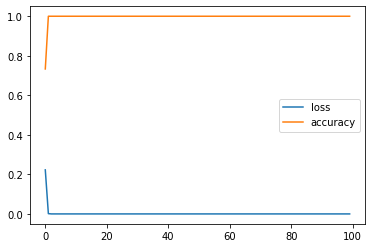

In [21]:
history = transfer_learner.fit(X, y, epochs=100, shuffle=True, verbose=0)

pd.DataFrame(history.history).plot();

epoch 수가 낮을때부터 loss는 0으로, accuracy는 1로 빠르게 접근하며 급격히 성능이 좋아지는 것을 볼 수 있다.  
즉, 사전훈련된 좋은 모델을 가져와서 기존 훈련결과를 활용하면 적은 훈련으로도 좋은 능력을 갖게 만들 수 있다는 것이다.

[1, 1, 0, 1, 0, 1, 0, 1, 0, 1]


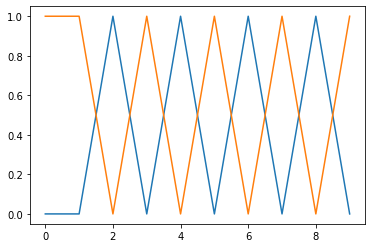

In [24]:
y_pred = transfer_learner.predict(test_images)
print([np.argmax(i) for i in y_pred])
plt.plot(y_pred);

### 3. VGG16으로 사람 얼굴 찾기
옥스퍼드 대학의 연구자들이 만든 모델이다.

In [29]:
from tensorflow.python.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', input_shape=(75,75,3), include_top=False)

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

VGG16은 훈련 가능한 파라미터가 총 약 1470만개인 모델인 것을 알 수 있다.  
이중 'block4_pool' layer까지만 사용하고, 이후는 우리가 원하는 출력이 되도록 전이학습 모델을 만들어보자.  
출력을 위한 layer들의 노드 수를 32로 축소해보자.

In [32]:
last_layer = model.get_layer('block4_pool')
last_output = last_layer.output

for layer in model.layers:
    layer.trainable = False
    
x = layers.Flatten()(last_output)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(2, activation='softmax')(x)

transfer_learner = Model(model.input, x)

transfer_learner.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

transfer_learner.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0   

훈련 가능한 파라미터가 약 26만개로 줄어든 것을 알 수 있다.

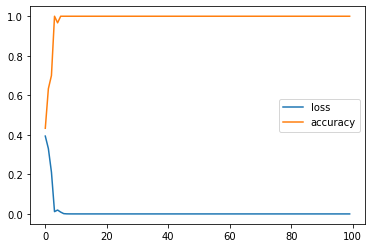

In [33]:
history = transfer_learner.fit(X, y, epochs=100, shuffle=True, verbose=0)

pd.DataFrame(history.history).plot();

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


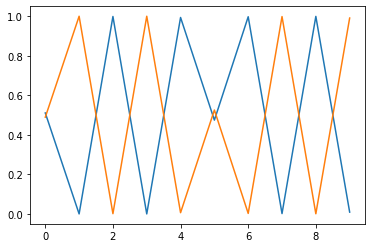

In [35]:
y_pred = transfer_learner.predict(test_images)
print([np.argmax(i) for i in y_pred])
plt.plot(y_pred);

신경망의 동작은 언제나 동일하지 않고, 난수에 의해 임의성을 갖기 때문에, 실행할 때마다 조금씩 달라질 수 있다.  
훈련을 통해 모델이 찾은 필터 역시 매번 달라지기 때문에 결과가 조금씩 변할 수는 있지만, 모델의 성능이 매우 높은 것은 확인할 수 있었다.  